<a href="https://colab.research.google.com/github/paulapipkin/sales_predictions/blob/main/Sales_Prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sales Prediciton

- Paula Pipkin

### Part 0 - Import Labraries and Load Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Importing Libaries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import set_config
set_config(display='diagram')





*   Load Data




In [3]:
df = pd.read_csv('/content/drive/MyDrive/BootCamp/PROJECT 1/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Part 1 & 2 - Pre cleaning, Cleaning and preaping for Vizualization

* Identify basic info: Nulls, Dtype, Columns and Rows 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


* Checking for unique values

In [5]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

* Checking for completly duplicated rows

In [6]:
df.duplicated().sum()


0

* Checking why fat_content has 5 different unique values 

according to the data dictionary we should only have 2 unique values

In [7]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

* Fixing values for fat content

In [8]:
df= df.replace(to_replace={'low fat', 'LF'}, value='Low Fat')
df= df.replace(to_replace={'reg'}, value='Regular')
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [9]:
df['Outlet_Type'].unique() # checking this one too, but it looks ok

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

* Checking on which types of item have more missing weight


In [10]:
df_missing_weight = df[df['Item_Weight'].isnull()]
df_missing_weight.groupby('Item_Type').size()

Item_Type
Baking Goods             112
Breads                    47
Breakfast                 21
Canned                   110
Dairy                    116
Frozen Foods             138
Fruits and Vegetables    213
Hard Drinks               31
Health and Hygiene        90
Household                151
Meat                      88
Others                    32
Seafood                   13
Snack Foods              212
Soft Drinks               71
Starchy Foods             18
dtype: int64

* Checking if there is missing values for 'Weight'  within an item identifier, so I could use the input to fill out missing inputs

In [11]:
sea_food_filter = df.loc[df['Item_Type']=='Seafood']
sea_food_filter.sort_values(by='Item_Identifier')


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7332,FDF33,7.97,Low Fat,0.036046,Seafood,107.5596,OUT010,1998,NaN,Tier 3,Grocery Store,431.4384
2761,FDF33,7.97,Low Fat,0.021531,Seafood,108.4596,OUT035,2004,Small,Tier 2,Supermarket Type1,3020.0688
8324,FDF33,7.97,Low Fat,0.021579,Seafood,105.9596,OUT045,2002,NaN,Tier 2,Supermarket Type1,2049.3324
4751,FDF33,NaN,Low Fat,0.000000,Seafood,109.4596,OUT027,1985,Medium,Tier 3,Supermarket Type3,1833.6132
3036,FDF33,7.97,Low Fat,0.021623,Seafood,107.6596,OUT018,2009,Medium,Tier 3,Supermarket Type2,1833.6132
...,...,...,...,...,...,...,...,...,...,...,...,...
1400,FDK45,11.65,Low Fat,0.033927,Seafood,111.5860,OUT045,2002,NaN,Tier 2,Supermarket Type1,3395.5800
1176,FDK45,NaN,Low Fat,0.059281,Seafood,111.5860,OUT019,1985,Small,Tier 1,Grocery Store,339.5580
6467,FDK45,11.65,Low Fat,0.033858,Seafood,113.3860,OUT046,1997,Small,Tier 1,Supermarket Type1,2603.2780
4952,FDK45,11.65,Low Fat,0.034050,Seafood,112.2860,OUT017,2007,NaN,Tier 2,Supermarket Type1,452.7440


In [12]:
baking_goods_filter = df.loc[df['Item_Type']=='Baking Goods']
baking_goods_filter.sort_values(by='Item_Identifier')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
5682,FDA11,NaN,Low Fat,0.043029,Baking Goods,94.7436,OUT027,1985,Medium,Tier 3,Supermarket Type3,1701.7848
2321,FDA11,7.75,Low Fat,0.043327,Baking Goods,95.6436,OUT045,2002,NaN,Tier 2,Supermarket Type1,1134.5232
6521,FDA11,7.75,Low Fat,0.043239,Baking Goods,92.5436,OUT046,1997,Small,Tier 1,Supermarket Type1,1701.7848
8316,FDA11,7.75,Low Fat,0.043483,Baking Goods,94.3436,OUT017,2007,NaN,Tier 2,Supermarket Type1,2363.5900
6604,FDA11,7.75,Low Fat,0.043415,Baking Goods,93.1436,OUT018,2009,Medium,Tier 3,Supermarket Type2,1418.1540
...,...,...,...,...,...,...,...,...,...,...,...,...
7127,FDZ60,20.50,Low Fat,0.119547,Baking Goods,108.9596,OUT049,1999,Medium,Tier 1,Supermarket Type1,539.2980
8133,FDZ60,20.50,Low Fat,0.119848,Baking Goods,109.4596,OUT018,2009,Medium,Tier 3,Supermarket Type2,431.4384
3811,FDZ60,NaN,Low Fat,0.208987,Baking Goods,106.0596,OUT019,1985,Small,Tier 1,Grocery Store,215.7192
2104,FDZ60,20.50,Low Fat,0.119339,Baking Goods,106.0596,OUT035,2004,Small,Tier 2,Supermarket Type1,970.7364


- I tested 2 different products and found out that each item identifier has a unique weight, but some are missing that info, so I will apply that same value to the missing ones, 

- since the weights are the same, I'm going to use the mean weight to fill up the null values in each item **BUT before, I'll make a copy of my data for ML**


In [13]:
df_ml = df.copy()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- missing values on df_ml will be haddled on part 5

* Now I will create a df for the weight for each item and use this df to map the missing values on my original df

In [14]:
mean_weight_per_item= df.groupby('Item_Identifier', as_index=False)['Item_Weight'].mean()
mean_weight_per_item.head(155) #I used 155 because I wanted to see item FDA11

,Item_Identifier,Item_Weight
0,DRA12,11.600
1,DRA24,19.350
2,DRA59,8.270
3,DRB01,7.390
4,DRB13,6.115
...,...,...
150,FDA08,11.850
151,FDA09,13.350
152,FDA10,20.350
153,FDA11,7.750


* From stackoverflow 'How to Fill Nulls with values in another dataframe in pandas, I'm mapping and filling the missing values

In [15]:
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Identifier'].map(mean_weight_per_item.set_index('Item_Identifier')['Item_Weight']))

# code from SO - df1['Col2'] = df1['Col2'].fillna(df1['Col1'].map(df2.set_index('Col1')['Col2']))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


* Missing only 4 weights now, I'll drop them

In [16]:
df.dropna(subset=['Item_Weight'],inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8519 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8519 non-null   object 
 1   Item_Weight                8519 non-null   float64
 2   Item_Fat_Content           8519 non-null   object 
 3   Item_Visibility            8519 non-null   float64
 4   Item_Type                  8519 non-null   object 
 5   Item_MRP                   8519 non-null   float64
 6   Outlet_Identifier          8519 non-null   object 
 7   Outlet_Establishment_Year  8519 non-null   int64  
 8   Outlet_Size                6109 non-null   object 
 9   Outlet_Location_Type       8519 non-null   object 
 10  Outlet_Type                8519 non-null   object 
 11  Item_Outlet_Sales          8519 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 865.2+ KB


* I'm going to use the same concept to the missing values for outlet size, since outlet identifier is unique and should have the same value for size


- Testing if hipotese is true (outlet size unique/outlet_id)


In [17]:
df.sort_values(by='Outlet_Identifier') #I can see that for each ID I have the same Size

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3227,NCH06,12.300,Low Fat,0.128136,Household,248.3460,OUT010,1998,NaN,Tier 3,Grocery Store,985.3840
2170,FDH10,21.000,Low Fat,0.082526,Snack Foods,191.8478,OUT010,1998,NaN,Tier 3,Grocery Store,774.9912
4265,FDS40,15.350,Low Fat,0.023466,Frozen Foods,35.2190,OUT010,1998,NaN,Tier 3,Grocery Store,36.6190
3216,DRI37,15.850,Low Fat,0.180097,Soft Drinks,57.3904,OUT010,1998,NaN,Tier 3,Grocery Store,117.1808
2172,FDJ44,12.300,Regular,0.177970,Fruits and Vegetables,173.1396,OUT010,1998,NaN,Tier 3,Grocery Store,697.7584
...,...,...,...,...,...,...,...,...,...,...,...,...
3939,FDO13,7.865,Low Fat,0.061155,Breakfast,165.3526,OUT049,1999,Medium,Tier 1,Supermarket Type1,1151.1682
3942,FDX11,16.000,Regular,0.106918,Baking Goods,183.5634,OUT049,1999,Medium,Tier 1,Supermarket Type1,4725.8484
3943,NCW41,18.000,Low Fat,0.000000,Health and Hygiene,158.0604,OUT049,1999,Medium,Tier 1,Supermarket Type1,3327.6684
7546,FDO52,11.600,Regular,0.077285,Frozen Foods,172.4106,OUT049,1999,Medium,Tier 1,Supermarket Type1,4277.7650


* Checking for 1 item


In [18]:
test_1_outlet = df.loc[df['Outlet_Identifier']=='OUT010']
test_1_outlet

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
30,FDV38,19.250,Low Fat,0.170349,Dairy,55.7956,OUT010,1998,NaN,Tier 3,Grocery Store,163.7868
45,FDM39,6.420,Low Fat,0.089499,Dairy,178.1002,OUT010,1998,NaN,Tier 3,Grocery Store,358.2004
65,FDC46,17.700,Low Fat,0.195068,Snack Foods,185.4266,OUT010,1998,NaN,Tier 3,Grocery Store,184.4266
...,...,...,...,...,...,...,...,...,...,...,...,...
8400,NCE07,8.180,Low Fat,0.021977,Household,140.6154,OUT010,1998,NaN,Tier 3,Grocery Store,425.4462
8432,FDI16,14.000,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920
8473,DRI47,14.700,Low Fat,0.035016,Hard Drinks,144.3128,OUT010,1998,NaN,Tier 3,Grocery Store,431.4384
8486,FDR20,20.000,Regular,0.000000,Fruits and Vegetables,46.4744,OUT010,1998,NaN,Tier 3,Grocery Store,45.2744


* The issue here is different, specific outlets don't have any entry on the outlet size, so I can't use one value to copy to other rows, because there is no value at all 


* checking how the category is spread out

In [19]:
df.groupby(by=['Outlet_Size'], dropna=False, as_index=False).size()

,Outlet_Size,size
0,High,932
1,Medium,2790
2,Small,2387
3,NaN,2410


* I will check how many store have their size missing

In [20]:
missing_size = df.loc[df['Outlet_Size'].isna()]
missing_size.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 3 to 8519
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            2410 non-null   object 
 1   Item_Weight                2410 non-null   float64
 2   Item_Fat_Content           2410 non-null   object 
 3   Item_Visibility            2410 non-null   float64
 4   Item_Type                  2410 non-null   object 
 5   Item_MRP                   2410 non-null   float64
 6   Outlet_Identifier          2410 non-null   object 
 7   Outlet_Establishment_Year  2410 non-null   int64  
 8   Outlet_Size                0 non-null      object 
 9   Outlet_Location_Type       2410 non-null   object 
 10  Outlet_Type                2410 non-null   object 
 11  Item_Outlet_Sales          2410 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 244.8+ KB


In [21]:
missing_size['Outlet_Identifier'].unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

In [22]:
df.groupby('Outlet_Identifier', as_index=False).size() # to see how representative in data, were each store

,Outlet_Identifier,size
0,OUT010,555
1,OUT013,932
2,OUT017,926
3,OUT018,928
4,OUT019,527
5,OUT027,932
6,OUT035,930
7,OUT045,929
8,OUT046,930
9,OUT049,930


* 3 stores out of 10 have no size entry I will use Medium for now, and using SimpleImputer for ML

In [23]:
df['Outlet_Size'] = df['Outlet_Size'].fillna('Medium')


* Obtaining the summary statistics of each (min, max, mean)for any numerical columns

In [24]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779
std,4.646098,0.051586,62.283594,8.369105,1706.511093
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026983,93.844900,1987.000000,834.247400
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


###Part 3 & 4 - Vizualization 

* Checking a general correlation between the numerical features

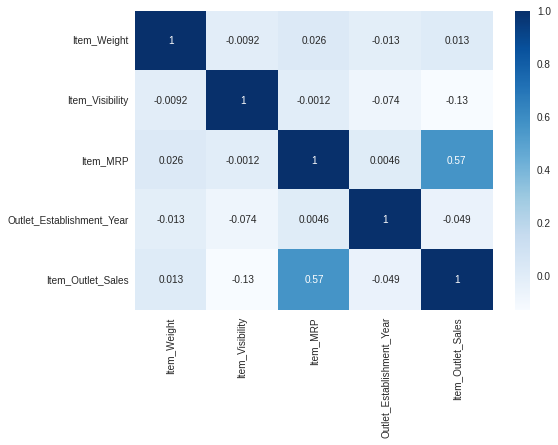

In [84]:
corr = df.corr()
sns.heatmap(corr, cmap='Blues', annot=True)
 
plt.savefig("heatmap.jpg", bbox_inches='tight') 


* I'll filter the items by category and see how this affects they correlation starting with the category with more items

In [69]:
df.groupby('Item_Type')['Item_Identifier'].nunique().sort_values()

Item_Type
Seafood                   10
Breakfast                 20
Others                    30
Starchy Foods             30
Hard Drinks               40
Breads                    45
Meat                      80
Soft Drinks               80
Health and Hygiene        95
Baking Goods             118
Canned                   120
Dairy                    124
Frozen Foods             154
Household                170
Snack Foods              219
Fruits and Vegetables    220
Name: Item_Identifier, dtype: int64

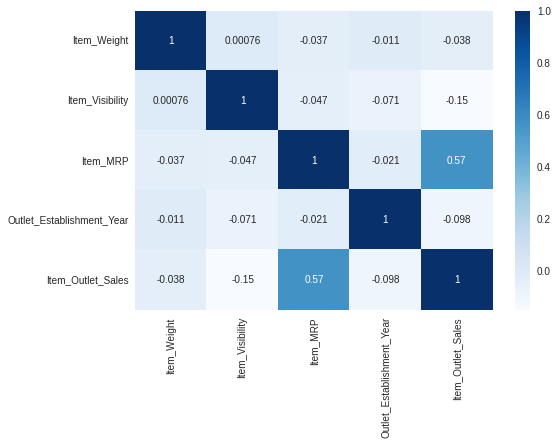

In [70]:
df_type_fruits = df.loc[df['Item_Type']=='Fruits and Vegetables']
corr_perType = df_type_fruits.corr()
sns.heatmap(corr_perType, cmap='Blues', annot=True);

* I thought that item visibility would have a positive correlation with sales, but that was not confirmed by the heat map

* Next I will check the distribution of the sales per location of the stores

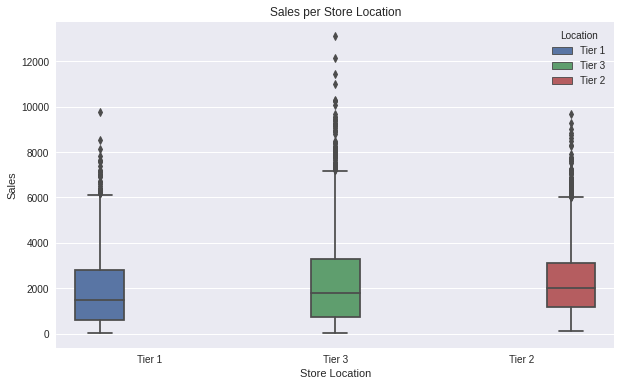

In [71]:
plt.figure(figsize=(10,6));
sns.boxplot(x='Outlet_Location_Type', y='Item_Outlet_Sales',hue='Outlet_Location_Type', data=df);
plt.legend(title='Location')
plt.xlabel('Store Location')
plt.ylabel('Sales')
plt.title('Sales per Store Location');

* Tier 3 seems to be doing slitgly better

* Let's check for the most expensives categories

In [72]:
mrp_type = df.groupby('Item_Type', as_index=False)['Item_MRP'].mean()


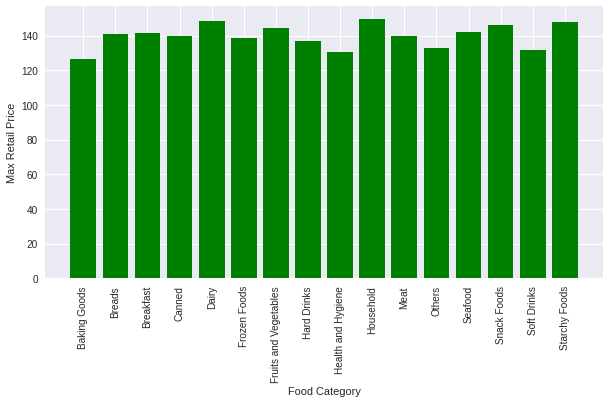

In [73]:
fig = plt.figure(figsize = (10, 5))
plt.bar(mrp_type['Item_Type'], mrp_type['Item_MRP'],color='green')
plt.xlabel('Food Category')
plt.ylabel('Max Retail Price')
plt.xticks(rotation=90);


* Let's check the MRP distribution




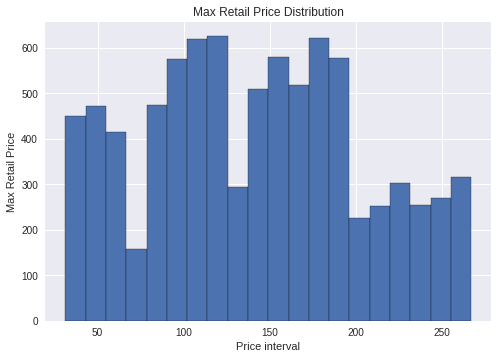

In [74]:
plt.style.use('seaborn')
df['Item_MRP'].hist(bins=20, edgecolor='black');
plt.ylabel('Max Retail Price')
plt.xlabel('Price interval')
plt.title('Max Retail Price Distribution');


* We might need to evaluate MRP per item ID or per type to make this data useful

* Now let's evaluate sales per store

In [75]:
store_filter = df.groupby('Outlet_Identifier', as_index=False)['Item_Outlet_Sales'].mean().sort_values(by='Item_Outlet_Sales')

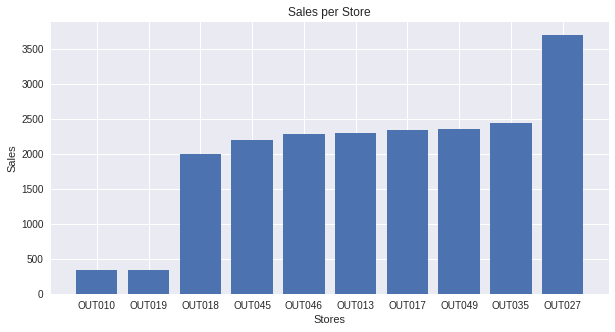

In [76]:
fig = plt.figure(figsize=(10,5))
plt.bar(store_filter['Outlet_Identifier'],store_filter['Item_Outlet_Sales'],data=store_filter)
plt.xlabel('Stores')
plt.ylabel('Sales')
plt.title('Sales per Store');


* We should further evaluate why the difference between OUT010, OUT019,OUT027




* As we have seen before OUT010, OUT019 have less sales inputs, maybe this difference affected the mean value,  but OUT027 have about the same as the other stores:

In [77]:
df.groupby('Outlet_Identifier', as_index=False).size().sort_values('size')

,Outlet_Identifier,size
4,OUT019,527
0,OUT010,555
2,OUT017,926
3,OUT018,928
7,OUT045,929
6,OUT035,930
8,OUT046,930
9,OUT049,930
1,OUT013,932
5,OUT027,932


* Trend Vizualization

- The top 2 items in terms of data inputs are being sold with different prices, let's check the difference

In [78]:
df_items = df['Item_Identifier'].value_counts()
df_items.head()

FDG33    10
FDW13    10
FDV60     9
FDU12     9
FDX20     9
Name: Item_Identifier, dtype: int64

In [79]:
top1_FDG33 = df.loc[df['Item_Identifier'] == 'FDG33',:].sort_values(by='Outlet_Identifier')
top2_FDW13 = df.loc[df['Item_Identifier'] == 'FDW13',:].sort_values(by='Outlet_Identifier')


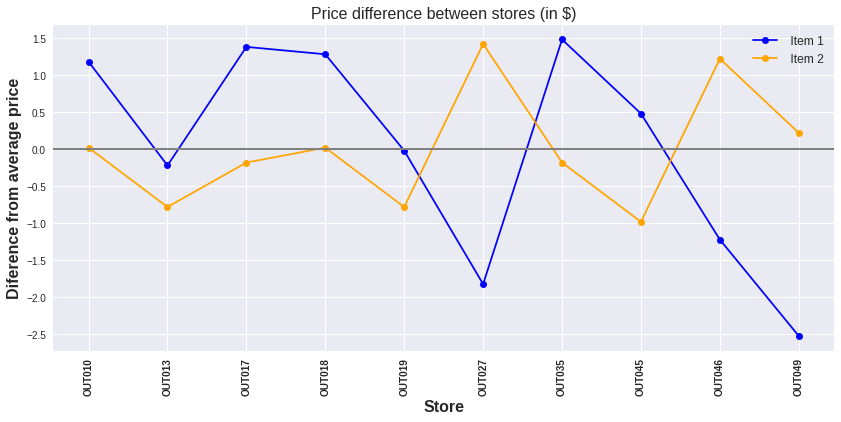

In [85]:
from matplotlib.image import BboxImage
fig, axes = plt.subplots(ncols=1, nrows=1, figsize =(14,6))
axes.plot(top1_FDG33['Outlet_Identifier'],(top1_FDG33['Item_MRP']- top1_FDG33['Item_MRP'].mean()), color='blue', marker='o', label= ' Item 1' )
axes.plot(top2_FDW13['Outlet_Identifier'],(top2_FDW13['Item_MRP']- top2_FDW13['Item_MRP'].mean()), color='orange', marker='o', label= ' Item 2' )
axes.axhline(0, color='gray', linewidth=2)
plt.title('Price difference between stores (in $)', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(rotation=90,  fontweight = 'bold')
plt.ylabel('Diference from average price', fontsize = 16, fontweight = 'bold')
plt.xlabel('Store', fontsize = 16,  fontweight = 'bold')

plt.savefig("items.jpg", bbox_inches='tight') ;

- Item 1 can vary up to $3.5 dollars from 1 store to another, 
- The higher prices don't always happen at the same store.
- Store 027 seems to be always out of the trend.



* Still using the top 2 items, Let's see if there is a correlation between number of sales and the different prices


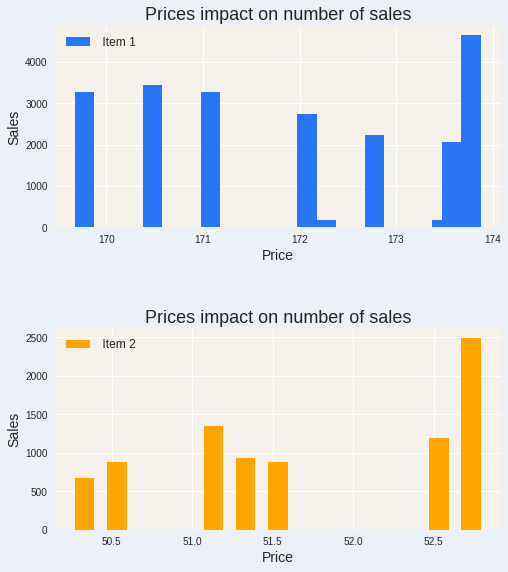

In [81]:

fig, axes = plt.subplots(ncols=1, nrows=2, figsize =(8,14))
fig.subplots_adjust(wspace=0.5, hspace=0.5, bottom=1, top= 1.5)
fig.set_facecolor('#ebf1f6')

axes[0].set_facecolor('#f6f2eb')
axes[1].set_facecolor('#f6f2eb')

axes[0].bar(top1_FDG33['Item_MRP'],top1_FDG33['Item_Outlet_Sales'], color='#2a74f6', label= ' Item 1', width=0.2 )
axes[1].bar(top2_FDW13['Item_MRP'],top2_FDW13['Item_Outlet_Sales'], color='orange',  label= ' Item 2' , width=0.12 )

axes[0].set_title('Prices impact on number of sales', fontsize=18)
axes[1].set_title('Prices impact on number of sales', fontsize=18)
axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)

axes[0].set_xlabel('Price', fontsize = 14)
axes[0].set_ylabel('Sales', fontsize = 14)
axes[1].set_xlabel('Price', fontsize = 14)
axes[1].set_ylabel('Sales', fontsize = 14);

* Having a lower price do not make your sales higher


###Part 5 - Prep for ML

* Reviewing data info

In [39]:
df_ml.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [40]:
df_ml.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [41]:
df_ml.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

- I'm only dropping column year of Establishment, I believe the others can at least be slightly relevant to the target, the amount of sales of a product.
- Why I'm not dropping Item or Outlet identifier, which is a unique feature per item? Because the same product is being sold in different stores with different prices and resulting in different amount of sales, I would think that make this information relevant.

* Spliting the data

In [42]:
X= df_ml.filter(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
'Item_Type', 'Item_MRP', 'Outlet_Identifier','Outlet_Size', 'Outlet_Location_Type'], axis=1)

y=df_ml['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

* Creating selectors to imput the missing data according to its type

In [43]:

cat_col_selector = make_column_selector(dtype_include='object')
num_col_selector = make_column_selector(dtype_include='number')

 - Based on the type of missing data I have I'll use 2 different types of imputers, one for categarical and one for numerical
 - Categorial will fill out the outlet size with the most frequent type, we only have 3 tyes of size, so I believe that using the most frequent will be enough to handle these values
 - Numerical will be used to fill out the missing data for the weight of the items with the mean weight

In [44]:
df_ml['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

* After imputing missing values we will scale the data

In [45]:
#create imputers and scalers
cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='mean')

scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')


* A pipeline will be applied to make the process more efficient

In [46]:
#create pipeline to make the process of imputing and scaling more efficient
cat_pipeline = make_pipeline(cat_imputer, ohe)
num_pipelene = make_pipeline(num_imputer, scaler)

In [47]:
#group in tuples
cat_tuple = (cat_pipeline, cat_col_selector)
num_tuple = (num_pipelene, num_col_selector)

In [48]:
#create processor
preprocessor = make_column_transformer(cat_tuple,num_tuple,remainder='drop')

* Fit the processor to imput and scale data

In [49]:
preprocessor.fit(X_train)

# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

* Checking the results

In [50]:
print(np.isnan(X_train_processed).sum().sum())
print(np.isnan(X_test_processed).sum().sum())


0
0


In [51]:
train_df_processed = pd.DataFrame(X_train_processed)
train_df_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.817249,-0.712775,1.828109
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.556340,-1.291052,0.603369
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.131512,1.813319,0.244541
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.169219,-1.004931,-0.952591
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.528819,-0.965484,-0.336460


In [52]:
test_df_processed = pd.DataFrame(X_test_processed)
test_df_processed.head()

,0,1,2,3,4,5,6,7,8,9,...,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.310089e-01,-0.776646,-0.998816
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-1.179892e+00,0.100317,-1.585194
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.784469e-01,-0.482994,-1.595784
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.213344e-16,-0.415440,0.506592
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-6.426567e-01,-1.047426,0.886725


* Now the data is scaled and has no missing values, let's try different types of models

###**Linear Regression Model**

In [53]:
lin_reg = LinearRegression()

* Fitting the model

In [54]:
lin_reg.fit(X_train_processed,y_train)

LinearRegression()

* Apply and check

In [55]:
lr_train_pred = lin_reg.predict(X_train_processed)
lr_test_pred = lin_reg.predict(X_test_processed)

* Evaluating R2 Score

In [56]:
r2_train_lr = r2_score(y_train, lr_train_pred)
r2_test_lr = r2_score(y_test, lr_test_pred)

print(f'Model training R2: {r2_train_lr.round(3)}')
print(f'Model test R2: {r2_test_lr.round(3)}')

Model training R2: 0.671
Model test R2: -4.658232076965837e+20


* Evaluating RMSE

In [57]:
train_RMSE_lr= np.sqrt(mean_squared_error(y_train,lr_train_pred))
test_RMSE_lr= np.sqrt(mean_squared_error(y_test, lr_test_pred))

print(f'Model Training RMSE: {train_RMSE_lr.round(2)}')
print(f'Model Test RMSE: {test_RMSE_lr.round(2)}')

Model Training RMSE: 987.04
Model Test RMSE: 35849625523401.44


### **Regression Tree Model**

- instantiate
- fit
- check scores
- tune 
- compare scores

In [58]:
dec_tree = DecisionTreeRegressor(random_state = 42)
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

* Save predictions for future evaluation

In [59]:
dt_test_predict = dec_tree.predict(X_test_processed)
dt_train_predict = dec_tree.predict(X_train_processed)

#### **Evaluate R2 Socore and RMSE** 

In [60]:
dt_train_score = dec_tree.score(X_train_processed, y_train)
dt_test_score = dec_tree.score(X_test_processed, y_test)
print(f'Model Training R2 Score:{dt_train_score.round(4)}')
print(f'Model Training R2 Score:{dt_test_score.round(4)}')

Model Training R2 Score:1.0
Model Training R2 Score:0.2226


Determine the depth of the default tree.

In [61]:
max_depth = dec_tree.get_depth()
max_depth

64

* using the max_depth to iterate and find the best parameter

In [62]:
depths = list(range(2, max_depth)) 

scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_processed, y_train)
    train_score_dt = dec_tree.score(X_train_processed, y_train)
    test_score_dt = dec_tree.score(X_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score_dt
    scores.loc[depth, 'Test Score'] = test_score_dt
   


In [63]:
sorted_scores_dt = scores.sort_values(by='Test Score', ascending=False)
dt_tuned = sorted_scores_dt.head(1)
dt_tuned

,Test Score,Train Score
6,0.588571,0.614447


RMSE

In [67]:
train_RMSE_dt = np.sqrt(mean_squared_error(y_train, dt_train_predict))
test_RMSE_dt = np.sqrt(mean_squared_error(y_test, dt_test_predict))

print(f'Model Training RMSE: {train_RMSE_dt.round(2)}')
print(f'Model Test RMSE: {test_RMSE_dt.round(2)}')

Model Training RMSE: 0.0
Model Test RMSE: 1464.49


* Comparing Models Metrics

In [65]:
final_scores = pd.DataFrame(index= ['Linear Regression R2', 'Linear Regression MRSE','Decision Tree R2', 'Decision Tree MRSE' ],columns=['Test Score', 'Train Score'])

final_scores['Test Score'].values[0] = r2_test_lr.round(4)
final_scores['Test Score'].values[1] = test_RMSE_lr.round(4)
final_scores['Test Score'].values[2] = dt_tuned['Test Score'].values[0].round(4)
final_scores['Test Score'].values[3] = test_RMSE_dt.round(4)

final_scores['Train Score'].values[0] = r2_train_lr.round(4)
final_scores['Train Score'].values[1] = train_RMSE_lr.round(4)
final_scores['Train Score'].values[2] = dt_tuned['Train Score'].values[0].round(4)
final_scores['Train Score'].values[3] = train_RMSE_dt.round(4)

final_scores

,Test Score,Train Score
Linear Regression R2,-465823207696583688192.0,0.6708
Linear Regression MRSE,35849625523401.445312,987.0396
Decision Tree R2,0.5886,0.6144
Decision Tree MRSE,1464.4947,0.0


###Conclusions

- *With a negative R2 score, you can safely assume that the model is a very poor fit to the data and a super large RMSE will only confirm that.
So based on the metrics results I wouldn't suggest a linear regression model to this data.* 


- *The Decision Tree yeld better metrics values, it is far from perfect, specially if we anallize the RMSE that is showing great difference between training and test data. But the R2 is around 60%, which indicates that more relevant features should be add to the data if we want to predict the sales with confidence, still, the model can now explain 60% of the variance on the results and between the 2 I would recomend Decision Tree over Linear Regression*  
